In [1]:
#!/usr/bin/env python

# conditions_WBGT_monthmax.ipynb

'''
    File name: conditions_WBGT_monthmax.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 04.30.2024
    Date last modified: 04.30.2024

    ############################################################## 
    Needs data from:
    papers/2024/2024_WBGT_Climate-Change/programs/process_conditions_WBGT_monthmax/process_conditions_WBGT_monthmax.ipynb
    
    Purpose:

    1) Read in preprocessed data
    2) Analyze the dependence between changes in WBGT and its source variables

'''

In [2]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import pickle
import time
import xarray as xr
from tqdm import tqdm
import matplotlib.gridspec as gridspec
import random

import warnings
warnings.filterwarnings("ignore")

### WBGT calculation function

In [3]:
# Create Python function for wbgt calculation
!pip install cftime
!pip install numba
# import general packages
import xarray as xr
import dask
import dask.array as da
import numpy as np
from matplotlib import pyplot as plt
from numba import njit, vectorize
# import packages needed for obtaining google cloud data
import pandas as pd
import fsspec
import sys 
from calendar import monthrange
# import functions for calculating cosine zenith angle
from coszenith import coszda, cosza
# import functions for calculating WBGT
from WBGT import WBGT_Liljegren, WBGT_GCM

def wbgt(huss,
        tas,
        ps,
        uas,
        vas,
        rlds,
        rsds,
        rlus,
        rsus,
        lat,
        lon,
        time):

    

    # function that creates the correct xarray data
    def xr_data(data,
            time_hh,
            lon,
            lat):
            

        lat = xr.DataArray(lat,
                               dims = ['x_logical', 'y_logical'])
        
        lon = xr.DataArray(lon,
                               dims = ['x_logical', 'y_logical'])
        
        
        new_array = xr.DataArray(data, dims=['time','x_logical','y_logical'])
        new_array.coords['lat'] = lat
        new_array.coords['lon'] = lon
        new_array.coords['time'] = time_hh
        new_array.groupby('lat').mean()
        
        ds = xr.Dataset({'testdata': (('time','y', 'x'), data)},
                         coords={'time': (('time'), time_hh),
                                 'lat': (('y', 'x'), lat.data),
                                 'lon': (('y', 'x'), lon.data)})
        
        data = xr.DataArray(ds.to_array()[0,:], dims=ds.dims, coords=ds.coords)
    
        return data

    # bring the input data into the correct format
    huss = xr_data(huss, time, lon, lat)
    tas = xr_data(tas, time, lon, lat)
    ps = xr_data(ps, time, lon, lat)
    uas = xr_data(uas, time, lon, lat)
    vas = xr_data(vas, time, lon, lat)
    rlds = xr_data(rlds, time, lon, lat)
    rsds = xr_data(rsds, time, lon, lat)
    rlus = xr_data(rlus, time, lon, lat)
    rsus = xr_data(rsus, time, lon, lat)
            
    # not nescessary with WRF interpolate radiation
    rsdsinterp=rsds
    rsusinterp=rsus
    rldsinterp=rlds
    rlusinterp=rlus
    # rsdsdiffinterp=interp(rsdsdiff)
    
    
    # In[12]:
    
    
    # # check that radiation fields have correct time coordinates
    # rsdsinterp.time
    
    
    # ### 3.2 calculate $\cos\theta$
    # We calculate $\cos\theta$ averaged both during each interval and during only the sunlit period of each interval. Both of them are needed for calculating WBGT. For the details of the calculation procedure of $\cos\theta$ please refer to Hogan and Hirahara (2016), and Di Napoli et al (2020)
    
    # In[13]:
    
    
    # create meshgrid of latitude and longitude, and we will calculate cosine zenith angle on these grids
    # lon,lat=np.meshgrid(huss.lon,huss.lat)
    
    lat=lat*np.pi/180
    lon=lon*np.pi/180
    
    
    # calculate $\cos\theta$ averaged during each interval.
    # 
    # the function ***cosza*** asks for four inputs: 
    # - a time series (UTC time) indicating the center points of intervals for which the $\cos\theta$ will be calculated
    # - the latitude and longitude arrays across which $\cos\theta$ will be calculated
    # - the length of each interval (e.g. 3 for 3hourly)
    
    # In[92]:
    
    
    # specifiy the time seris for which we want to calculate cosine zenith angle 
    date=xr.DataArray(huss.time.values,dims=('time'),coords={'time':huss.time}).chunk({'time':8})
    # use dask.array map_blocks to calculate cosine zenith angle lazily and parallelly
    cza=da.map_blocks(cosza,date.data,lat,lon,3,chunks=(np.min([huss.shape[0], 8]),lat.shape[0],lat.shape[1]),new_axis=[1,2])
    # transfer to xarray DataArray
    cza=np.array(xr.DataArray(cza,dims=huss.dims, coords=huss.coords))
    
    # specifiy the time seris for which we want to calculate cosine zenith angle 
    date=xr.DataArray(huss.time.values,dims=('time'),coords={'time':huss.time}).chunk({'time':8})
    # use dask.array map_blocks to calculate cosine zenith angle lazily and parallelly
    cza=da.map_blocks(cosza,date.data,lat,lon,3,chunks=(np.min([huss.shape[0], 8]),lat.shape[0],lat.shape[1]),new_axis=[1,2])
    # transfer to xarray DataArray
    cza=np.array(xr.DataArray(cza,dims=huss.dims, coords=huss.coords))
    
    # calculate $\cos\theta$ averaged during only the sunlit part of each interval.
    # 
    # the function ***coszda*** asks for four inputs: 
    # - a time series (UTC time) indicating the center points of intervals for which the $\cos\theta$ will be calculated
    # - the latitude and longitude arrays across which $\cos\theta$ will be calculated
    # - the length of each interval (e.g. 3 for 3hourly)
    
    
    
    czda=da.map_blocks(coszda,date.data,lat,lon,3,chunks=(np.min([huss.shape[0], 8]),lat.shape[0],lat.shape[1]),new_axis=[1,2])
    # transfer to xarray DataArray
    czda=xr.DataArray(czda,dims=huss.dims, coords=huss.coords)
    # here we change zero (czda=0 when the sun is below horizon) to an arbitrary negative value (here we choose -0.5) to avoid division by zero 
    czda=xr.where(czda<=0,-0.5,czda)
    
    
    # Have a look at the $\cos\theta$ for the first time step
    
    # # In[16]:
    
    
    # cza[0,:,:].plot()
    
    
    # # In[17]:
    
    
    # czda[0,:,:].plot()
    
    
    # ### 3.3 Calculate relative humidity
    # Here we calculate relative humidity from specific humidity since relative humidity is one of the required inputs for WBGT function.
    
    
    # calculate saturated vapor pressure
    @vectorize
    def esat(tas,ps):
        # tas: temperature (K)
        # ps: surface pressure (Pa)
        # return saturation vapor pressure (Pa)
        if tas>273.15:
            es = 611.21 * np.exp(17.502 * (tas - 273.15) *((tas - 32.18)**(-1)))
            es = (1.0007 + (3.46*10**(-6) * ps/100)) * es
        else:
            es = 611.15 * np.exp(22.452 * (tas - 273.15) * ((tas - 0.6)**(-1)))
            es=(1.0003 + (4.18*10**(-6) * ps/100)) * es
        return es
    # calculate vapor pressure
    def vaporpres(huss, ps):
        # huss: specific humidity (kg/kg)
        # ps: surface pressure (Pa)
        # return vapor pressure (Pa)
        r=huss*((1-huss)**(-1))
        return ps*r*((0.622+r)**(-1))
    # calculate relative humidity from specific humidity
    def huss2rh(tas,huss,ps):
        # tas: temperature (K)
        # huss: specific humidity (kg/kg)
        # ps: surface pressure (Pa)
        # return relative humidity (%)
        return vaporpres(huss, ps)*(esat(tas,ps)**(-1))*100
    
    
    # In[19]:
    
    
    # calculate relative humidity
    hurs=xr.apply_ufunc(huss2rh,tas,huss,ps) #,dask="parallelized",output_dtypes=[float])
    # set the maximum value as 100%
    hurs=xr.where(hurs>100,100,hurs)
    
    
    # ### 3.4 Calculate wind speed
    # Calculate wind speed from the u and v components of wind. Keep in mind that the wind speed are output at 10m height. Our WBGT function will ask for a boolean argument to indicate whether 2m (```True```) or 10m (```False```) wind is used.
    
    # In[38]:
    
    
    func = lambda x, y: np.sqrt(x ** 2 + y ** 2)
    # sfcwind=xr.apply_ufunc(func, uas, vas) #,dask="parallelized",output_dtypes=[float])
    sfcwind = np.sqrt(uas ** 2 + vas ** 2)
    
    
    # ### 3.5 Calculate the ratio of direct solar radiation
    # We need to know the ratio of direct solar radiation in order to get the radiation heat gain right for WBGT calculation, since the treatment of direct and diffuse solar radiation are different in the code. 
    # 
    # In this case, we have ```rsdsdiff``` which is the diffuse solar radiation, so we can directly calculate the ratio of direct solar radiation. 
    # 
    # When we don't have such a field, we need to call the **```fdir```** function (also can be imported from the ```WBGT``` module) to calculate the ratio. Please refer to the ```WBGT.pyx``` file for how to call **```fdir```** function.
    
    # In[39]:
    
    
    from WBGT import fdir, fdir_3d
    # In[40]:
    
    f=fdir_3d(np.atleast_3d(cza),np.atleast_3d(czda),np.atleast_3d(rsds),date)
    
    
    # In[41]:
    
    
    # f=(rsdsinterp-rsdsdiffinterp)/rsdsinterp 
    # the treatments below aim to avoid unrealistically high or low values of f which are also included in Liljegren's code.
    f=xr.where(cza<=np.cos(89.5/180*np.pi),0,f) 
    f=xr.where(f>0.9,0.9,f)
    f=xr.where(f<0,0,f)
    f=xr.where(rsdsinterp<=0,0,f)
    
    
    # # 4. Calculate WBGT
    
    # ### 4.1 Liljegren's original formulation
    # In Liljegren's original formulation, downward solar radiation is the only required radiation input, other radiation components are approximated internally.
    # 
    # The meaning of each argument:
    # - ```tas```: air temperature (K)
    # -  ```hurs```: relative humidity (%)
    # -  ```sfcwind```: 2 meter wind speed (m/s)
    # -  ```ps```: surface pressure (Pa)
    # -  ```rsdsinterp```: surface downward solar radiation (w/m2)
    # -  ```f```: the ratio of direct solar radiation 
    # - ```czda```: average cosine zenith angle during only the sunlit period of each interval
    # 
    # -  the ```False``` argument at the end tell the function that our wind speed is not at 2meter height which will make  the function to treat wind speed as 10 meter height and transfer it to 2 meter. The function currently only support 2 meter and 10meter wind. For wind speed at other heights, users need to change the source code slightly.
    
    # In[45]:
    
    
    wbgt_liljegren=xr.apply_ufunc(WBGT_Liljegren,tas,hurs,ps,sfcwind,rsdsinterp,f,czda,False,dask="parallelized",output_dtypes=[float])
    
    
    # We also exposed the functions for calculating natural wet bulb temperature and black globe temperature, two important components of WBGT
    
    # In[46]:
    
    
    from WBGT import Tg_Liljegren, Tnwb_Liljegren
    
    
    # In[48]:
    
    
    # calculate black globe temperature
    tg_liljegren=xr.apply_ufunc(Tg_Liljegren,tas,hurs,ps,sfcwind,rsdsinterp,f,czda,False,dask="parallelized",output_dtypes=[float])
    
    
    # In[49]:
    
    
    # calculate natural wet bulb temperature
    tnwb_liljegren=xr.apply_ufunc(Tnwb_Liljegren,tas,hurs,ps,sfcwind,rsdsinterp,f,czda,False,dask="parallelized",output_dtypes=[float])
    
    
    # Let's plot calculated WBGT at the last time step
    
    # In[ ]:
    
    
    # plt.pcolormesh(wbgt_liljegren[-1,:,:]-273, cmap='coolwarm')
    
    
    # ### 4.2 Our modified formulation
    # We modify Liljegren's original code to take advantage of the full set of radiation components available from climate model output. 
    # 
    # The meaning of each argument:
    # - ```tas```: air temperature (K)
    # -  ```hurs```: relative humidity (%)
    # -  ```sfcwind```: 2 meter wind speed (m/s)
    # -  ```ps```: surface pressure (Pa)
    # -  ```rsdsinterp```: surface downward solar radiation (w/m2)
    # -  ```rsusinterp```: surface reflected solar radiation (w/m2)
    # -  ```rldsinterp```: surface downward long-wave radiation (w/m2)
    # -  ```rlusinterp```: surface upwelling long-wave radiation (w/m2)
    # - ```f```: the ratio of direct solar radiation 
    # -  ```czda```: average cosine zenith angle during only the sunlit period of each interval
    # - ```False```: indicate we are using 10m wind
    
    # In[51]:
    
    
    # calculate WBGT
    wbgt_gcm=xr.apply_ufunc(WBGT_GCM,tas,hurs,ps,sfcwind,rsdsinterp,rsusinterp,rldsinterp,rlusinterp,f,czda,False,dask="parallelized",output_dtypes=[float])
    
    
    # calculate components of WBGT
    
    # from WBGT import Tg_GCM, Tnwb_GCM
    
    
    
    # # calculate black globe temperature
    # tg_gcm=xr.apply_ufunc(Tg_GCM,tas,ps,sfcwind,rsdsinterp,rsusinterp,rldsinterp,rlusinterp,f,czda,False, dask="parallelized",output_dtypes=[float])
    
    
    # # calculate natural wet bulb temperature
    # tnwb_gcm=xr.apply_ufunc(Tnwb_GCM,tas,hurs,ps,sfcwind,rsdsinterp,rsusinterp,rldsinterp,rlusinterp,f,czda,False,dask="parallelized",output_dtypes=[float])
    
    
    # Let's plot monthly average WBGT.
    
    
    # # wbgt_gcm.mean('time').plot()
    # plt.pcolormesh(wbgt_gcm[-1,:,:]-273, cmap='coolwarm', vmin=-40,vmax=40)
    
    ### Save data to netcdf
    return wbgt_gcm.load()

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### User imput section

In [4]:
data_dir = '/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/WBGT_monmax_variables/'
savedir = '/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/city_changes/'

time_c404_ctr = pd.date_range(datetime.datetime(1980, 1, 1, 0), 
                              end=datetime.datetime(2019, 12, 31, 23), freq='h')
years_ctr = np.unique(time_c404_ctr.year)
conus404_pgw_dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData_PGW/'
time_c404_pgw = pd.date_range(datetime.datetime(1980, 1, 1, 0), 
                              end=datetime.datetime(2011, 12, 31, 23), freq='h')
years_pgw = np.unique(time_c404_pgw.year)

variables = ['GWBT','T2','Q2','PSFC','U10','V10','LWDNB','SWDNB','LWUPB','SWUPB']


### Load global average LENS2 temperature for warming level selection

In [5]:
data = pd.read_csv('/glade/u/home/prein/papers/2024/2024_WBGT_Climate-Change/data/NASA_global-av_t2m/graph.txt', delimiter=r"\s+", header=0, skiprows=[0,1,2,4])

StartDay = datetime.datetime(1850, 1, 15,1)
StopDay = datetime.datetime(2101, 1, 15,0)
Time=pd.date_range(StartDay, end=StopDay, freq='M')
Time_years=pd.date_range(StartDay, end=StopDay, freq='Y')
years = np.unique(Time.year)

reference_period = [1950, 1980]

lens2_t2m_dir = '/glade/campaign/mmm/c3we/mingge/DOD/LENS2/'
ncid=Dataset(lens2_t2m_dir + 'TREFMNAV_monthly_globalAvg_185001-197912.nc', mode='r')
TREFMNAV_hist = np.array(np.squeeze(ncid.variables['TREFMNAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMNAV_monthly_globalAvg_198001-201412.nc', mode='r')
TREFMNAV_cur = np.array(np.squeeze(ncid.variables['TREFMNAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMNAV_monthly_globalAvg_201501-210012.nc', mode='r')
TREFMNAV_fut = np.array(np.squeeze(ncid.variables['TREFMNAV'][:]))
ncid.close()

ncid=Dataset(lens2_t2m_dir + 'TREFMXAV_monthly_globalAvg_185001-197912.nc', mode='r')
TREFMXAV_hist = np.array(np.squeeze(ncid.variables['TREFMXAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMXAV_monthly_globalAvg_198001-201412.nc', mode='r')
TREFMXAV_cur = np.array(np.squeeze(ncid.variables['TREFMXAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMXAV_monthly_globalAvg_201501-210012.nc', mode='r')
TREFMXAV_fut = np.array(np.squeeze(ncid.variables['TREFMXAV'][:]))
ncid.close()

TREFMNAV = np.append(TREFMNAV_hist, TREFMNAV_cur, axis=1)
TREFMNAV = np.append(TREFMNAV, TREFMNAV_fut, axis=1)
TREFMXAV = np.append(TREFMXAV_hist, TREFMXAV_cur, axis=1)
TREFMXAV = np.append(TREFMXAV, TREFMXAV_fut, axis=1)
lens2_t2m = (TREFMNAV + TREFMXAV) / 2.

lens2_t2m_y = np.mean(np.reshape(lens2_t2m, (lens2_t2m.shape[0], int(lens2_t2m.shape[1]/12), 12)), axis=2)

ref_t2m = np.mean(lens2_t2m_y[:,(years >= reference_period[0]) & (years <= reference_period[1])])
time_to_t2m = np.mean(lens2_t2m_y, axis=0) - ref_t2m

dc_hist = np.arange(0,1.5,0.1)
dc_pgw = np.arange(0,3.5,0.1)
dc = 0.5 # deg. C

ref_period = [1950,1979]

era5_ref = np.mean(data['No_Smoothing'][(data['Year'] >= ref_period[0]) & (data['Year'] <= ref_period[1])])
era5_warming = np.squeeze(np.array([data['No_Smoothing'][data['Year'] == yy] - era5_ref for yy in range(1980,2021,1)]))

lens2_ref = np.mean(time_to_t2m[(years >= ref_period[0]) & (years <= ref_period[1])])
lens2_warming = np.array([time_to_t2m[years == yy][0] - lens2_ref for yy in range(2022,2022+len(np.unique(time_c404_pgw.year)),1)])

pgw_warming = np.zeros((len(years_ctr))); pgw_warming[:] = np.nan
for yy in range(len(years_ctr)):
    lens_hist = (years <= years_ctr[yy] + 5) & (years >= years_ctr[yy] - 5)
    lens_fut = (years <= years_ctr[yy] + 40 + 5) & (years >= years_ctr[yy] + 40 - 5)
    pgw_warming[yy] = data['No_Smoothing'][years_ctr[yy] == data['Year']] + np.mean(time_to_t2m[lens_fut]) - np.mean(time_to_t2m[lens_hist])

In [6]:
warming_tar = 0.25
targ_years_ref = (era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)

warming_tar = 2
targ_years = (pgw_warming[:len(years_pgw)] >= warming_tar - dc) & (pgw_warming[:len(years_pgw)] <= warming_tar + dc)

# Read CONUS404 CTR OR PGW WBGT DATA

In [7]:
# read CONUS404 coordinates
ncid=Dataset('/glade/campaign/ncar/USGS_Water/CONUS404/wrfconstants_d01_1979-10-01_00:00:00.nc4', mode='r')
lon_conus = np.array(np.squeeze(ncid.variables['XLONG'][:]))
lat_conus = np.array(np.squeeze(ncid.variables['XLAT'][:]))
ncid.close()

In [8]:
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.feature as cf
import cartopy.crs as ccrs
GEO_EM_D1 = '/glade/u/home/prein/projects/2020/2020_CONUS404/programs/plots/Domain/geo_em.d01.nc'
ncfile = Dataset(GEO_EM_D1)
HGT_M = getvar(ncfile, "HGT_M")
LU = getvar(ncfile, "LU_INDEX")
cart_proj = get_cartopy(HGT_M)
ncid.close()

In [9]:
ctr_data = np.zeros((len(years_ctr),12,lon_conus.shape[0],lon_conus.shape[1],len(variables))); ctr_data[:] = np.nan
ctr_time = np.empty((len(years_ctr),12,lon_conus.shape[0],lon_conus.shape[1]), dtype='datetime64[s]')

In [10]:
for yy in tqdm(range(len(years_ctr))):
    for mm in range(12):
        datafile = data_dir + str(years_ctr[yy]) + str(mm+1).zfill(2) +'_WBGT_monmax_variables_ctr.npz'
        if os.path.isfile(datafile) == True:
            data = np.load(datafile)
            ctr_data[yy,mm,:,:,:] = data['conus_ctr']
            ctr_time[yy,mm,:] = data['timestamp_max']

100%|██████████| 40/40 [04:09<00:00,  6.23s/it]


In [11]:
pgw_data = np.zeros((len(years_pgw),12,lon_conus.shape[0],lon_conus.shape[1],len(variables))); pgw_data[:] = np.nan
pgw_time = np.empty((len(years_pgw),12,lon_conus.shape[0],lon_conus.shape[1]), dtype='datetime64[s]')

In [12]:
for yy in tqdm(range(len(years_pgw))):
    for mm in range(12):
        datafile = data_dir + str(years_pgw[yy]) + str(mm+1).zfill(2) +'_WBGT_monmax_variables_pgw.npz'
        if os.path.isfile(datafile) == True:
            data = np.load(datafile)
            pgw_data[yy,mm,:,:,:] = data['conus_ctr']
            pgw_time[yy,mm,:] = data['timestamp_max']

100%|██████████| 32/32 [03:28<00:00,  6.50s/it]


In [13]:
month_max = np.nanargmax(ctr_data[:,:,:,:,0], axis=1)
y,la,lo = np.indices(ctr_data[:,0,:,:,0].shape)

ymax_ctr = np.copy(ctr_data[:,0,:,:,:]); ymax_ctr[:]=np.nan
for va in tqdm(range(len(variables))):
    ymax_ctr[:,:,:,va] = ctr_data[y, month_max, la, lo, va]
ytime_ctr = ctr_time[y, month_max, la, lo]

100%|██████████| 10/10 [00:28<00:00,  2.85s/it]


In [14]:
month_max = np.nanargmax(pgw_data[:,:,:,:,0], axis=1)
y,la,lo = np.indices(pgw_data[:,0,:,:,0].shape)

ymax_pgw = np.copy(pgw_data[:,0,:,:,:]); ymax_pgw[:]=np.nan
for va in tqdm(range(len(variables))):
    ymax_pgw[:,:,:,va] = pgw_data[y, month_max, la, lo, va]
ytime_pgw = pgw_time[y, month_max, la, lo]

100%|██████████| 10/10 [00:23<00:00,  2.33s/it]


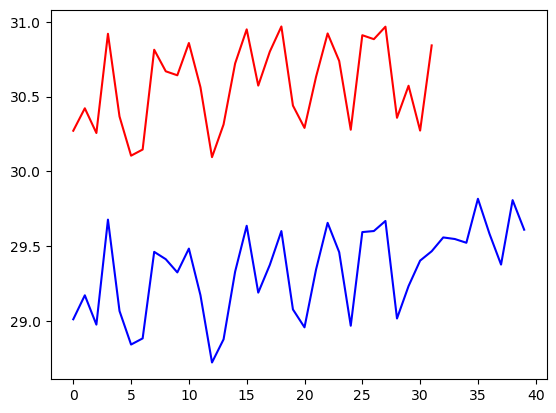

In [15]:
plt.plot(np.nanmean(np.nanmax(pgw_data[:,:,:,:,0], axis=(1)), axis=(1,2))-273.15, c='r')
plt.plot(np.nanmean(np.nanmax(ctr_data[:,:,:,:,0], axis=(1)), axis=(1,2))-273.15, c='b')

# plt.plot(c_pgw_years, np.nanmean(conus_pgw_wbgt, axis=(1,2))-273.15, c='r')

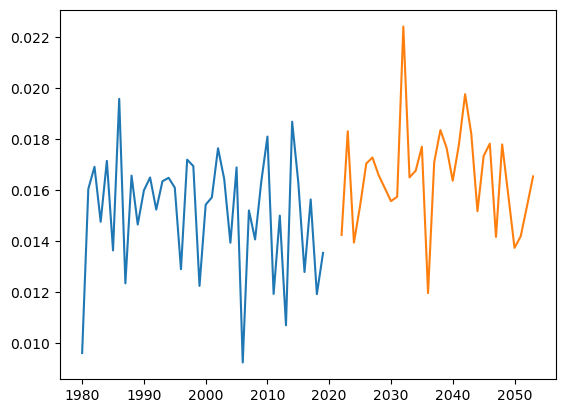

In [16]:
# plt.plot(years_ctr, ymax_ctr[:,360,380,0]-273.15, c='k')
plt.plot(years_ctr, ymax_ctr[:,360,380,2])

# plt.plot(years_pgw+42, ymax_pgw[:,360,380,0]-273.15, c='k')
plt.plot(years_pgw+42, ymax_pgw[:,360,380,2])

In [17]:
cities = ['Phoenix',
          'Miami',
          'New Orleans',
          'Houston',
          'Atlanta',
          'DC',
          # 'Yuma',
          'Sacramento',
          'Dalas',
          'Charlotte',
          'Chicago',
          'New York City',
          'Tampa',
            ]
city_loc = [
            [[350,370],[370,390]],
            [[1120,1135],[170,225]],
            [[860,880],[255,265]],
            [[730,760],[240,270]],
            [[980,1000],[373,400]],
            [[1110,1135],[540,575]],
            # [[292,300],[365,370]],
            [[180,195],[550,570]],
            [[685,720],[325,350]],
            [[1055,1070],[430,450]],
            [[875,900],[780,810]],
            [[1160,1180],[600,635]],
            [[1055,1070],[230,240]],
           ]

temp_channge = np.arange(0,3.1,0.1)
delta_t = 0.25
minyears = 7

In [18]:
cy=cities.index('Atlanta')
ctr_data = ymax_ctr[:,city_loc[cy][1][0]:city_loc[cy][1][1],
                                        city_loc[cy][0][0]:city_loc[cy][0][1]]
pgw_data = ymax_pgw[:,city_loc[cy][1][0]:city_loc[cy][1][1],
                                        city_loc[cy][0][0]:city_loc[cy][0][1]]

In [19]:
change_vars = [['T2'],
               ['Q2'],
               ['PSFC'],
               ['U10','V10'],
               ['LWDNB','LWUPB'],
               ['SWDNB','SWUPB']]

change_var_categories = ['T2','Q2','PSFC','UV10', 'LW', 'SW']
change_cat_colors = ['#e31a1c','#1f78b4','#969696','#33a02c','#a6cee3','#fb9a99']

city_cells = 50
change_sensitivities = np.zeros((ymax_pgw.shape[0], len(cities), city_cells, len(change_vars))); change_sensitivities[:] = np.nan
ctr_original_data = np.zeros((ymax_ctr.shape[0], len(cities), city_cells)); ctr_original_data[:] = np.nan
pgw_original_data = np.zeros((ymax_pgw.shape[0], len(cities), city_cells)); pgw_original_data[:] = np.nan

for cy in range(len(cities)):
    print(cities[cy])
    savefile =  savedir + cities[cy] + '_' + str(city_cells) + 'gc_statistics.npz'
    if os.path.isfile(savefile) == False:
        city_gc = LU[city_loc[cy][1][0]:city_loc[cy][1][1],
                     city_loc[cy][0][0]:city_loc[cy][0][1]] != 13 # 13 is urban
        ctr_data = ymax_ctr[:,city_loc[cy][1][0]:city_loc[cy][1][1],
                                        city_loc[cy][0][0]:city_loc[cy][0][1]]
        ctr_data = np.copy(ctr_data[:,city_gc])
        time_ctr_sel = ytime_ctr[yy, city_loc[cy][1][0]:city_loc[cy][1][1],
                                     city_loc[cy][0][0]:city_loc[cy][0][1]][city_gc]
    
        pgw_data = ymax_pgw[:,city_loc[cy][1][0]:city_loc[cy][1][1],
                                        city_loc[cy][0][0]:city_loc[cy][0][1]]
        pgw_data = np.copy(pgw_data[:,city_gc])
        
        lat_sel = lat_conus[city_loc[cy][1][0]:city_loc[cy][1][1],
                                        city_loc[cy][0][0]:city_loc[cy][0][1]][city_gc]
        lon_sel = lon_conus[city_loc[cy][1][0]:city_loc[cy][1][1],
                                        city_loc[cy][0][0]:city_loc[cy][0][1]][city_gc]
        time_pgw_sel = ytime_pgw[yy, city_loc[cy][1][0]:city_loc[cy][1][1],
                                     city_loc[cy][0][0]:city_loc[cy][0][1]][city_gc]
        
        cell_sel = np.array([random.randint(0, ctr_data.shape[1]) for ii in range(np.min([city_cells, pgw_data.shape[1]]))])
        # for ce in tqdm(range(np.min([city_cells, pgw_data.shape[1]]))):
            # ctr_data_sel = np.copy(ctr_data[:,cell_sel[ce],:])
            # pgw_data_sel = np.copy(pgw_data[:,cell_sel[ce],:])
    
        #     # calculate unperturbed WBGT (is necessary because values are not exactly the same)
        #     ctr_original_data[:,cy,ce] = ctr_data_sel[:,variables.index('GWBT')]
        #     pgw_original_data[:,cy,ce] = pgw_data_sel[:,variables.index('GWBT')]
        #     # print('full change signal orig: '+ str(np.nanmean(pgw_data_sel[:,variables.index('GWBT')]) - np.nanmean(ctr_data_sel[:,variables.index('GWBT')])))
            
        #     for yy in range(ymax_ctr.shape[0]):
        #         ctr_original_data[yy,cy,ce] = wbgt(ctr_data_sel[yy,variables.index('Q2')][None,None,None],
        #                                 ctr_data_sel[yy,variables.index('T2')][None,None,None],
        #                                 ctr_data_sel[yy,variables.index('PSFC')][None,None,None],
        #                                 ctr_data_sel[yy,variables.index('U10')][None,None,None],
        #                                 ctr_data_sel[yy,variables.index('V10')][None,None,None],
        #                                 ctr_data_sel[yy,variables.index('LWDNB')][None,None,None],
        #                                 ctr_data_sel[yy,variables.index('SWDNB')][None,None,None],
        #                                 ctr_data_sel[yy,variables.index('LWUPB')][None,None,None],
        #                                 ctr_data_sel[yy,variables.index('SWUPB')][None,None,None],
        #                                 lat_sel[cell_sel[ce]][None,None],
        #                                 lon_sel[cell_sel[ce]][None,None],
        #                                 np.array([time_ctr_sel[cell_sel[ce]]]))
        #     for yy in range(ymax_pgw.shape[0]):
        #         pgw_original_data[yy,cy,ce] = wbgt(pgw_data_sel[yy,variables.index('Q2')][None,None,None],
        #                                 pgw_data_sel[yy,variables.index('T2')][None,None,None],
        #                                 pgw_data_sel[yy,variables.index('PSFC')][None,None,None],
        #                                 pgw_data_sel[yy,variables.index('U10')][None,None,None],
        #                                 pgw_data_sel[yy,variables.index('V10')][None,None,None],
        #                                 pgw_data_sel[yy,variables.index('LWDNB')][None,None,None],
        #                                 pgw_data_sel[yy,variables.index('SWDNB')][None,None,None],
        #                                 pgw_data_sel[yy,variables.index('LWUPB')][None,None,None],
        #                                 pgw_data_sel[yy,variables.index('SWUPB')][None,None,None],
        #                                 lat_sel[cell_sel[ce]][None,None],
        #                                 lon_sel[cell_sel[ce]][None,None],
        #                                 np.array([time_pgw_sel[cell_sel[ce]]]))
            
    
        #     # print('full change signal calc: '+ str(np.nanmean(pgw_original_data[:,cy,ce]) - np.nanmean(ctr_original_data[:,cy,ce])))
            
        #     for va in range(len(change_vars)):
        #         pgw_data_noTchange = np.copy(pgw_data_sel)
        #         for sv in range(len(change_vars[va])):
        #             ivar = variables.index(change_vars[va][sv])
        #             pgw_data_noTchange[:,ivar] = pgw_data_noTchange[:,ivar] - \
        #                 (np.nanmean(pgw_data_sel[:,ivar]) - np.nanmean(ctr_data_sel[:,ivar]))
    
        #         # print(-(np.nanmean(pgw_data_sel[:,ivar]) - np.nanmean(ctr_data_sel[:,ivar])))
        #         for yy in range(ymax_pgw.shape[0]):
        #             change_sensitivities[yy,cy,ce,va] = wbgt(pgw_data_noTchange[yy,variables.index('Q2')][None,None,None],
        #                                 pgw_data_noTchange[yy,variables.index('T2')][None,None,None],
        #                                 pgw_data_noTchange[yy,variables.index('PSFC')][None,None,None],
        #                                 pgw_data_noTchange[yy,variables.index('U10')][None,None,None],
        #                                 pgw_data_noTchange[yy,variables.index('V10')][None,None,None],
        #                                 pgw_data_noTchange[yy,variables.index('LWDNB')][None,None,None],
        #                                 pgw_data_noTchange[yy,variables.index('SWDNB')][None,None,None],
        #                                 pgw_data_noTchange[yy,variables.index('LWUPB')][None,None,None],
        #                                 pgw_data_noTchange[yy,variables.index('SWUPB')][None,None,None],
        #                                 lat_sel[cell_sel[ce]][None,None],
        #                                 lon_sel[cell_sel[ce]][None,None],
        #                                 np.array([time_pgw_sel[cell_sel[ce]]]))
    
        #         # print(change_var_categories[va]+' '+str(np.mean(pgw_original_data[:,cy,ce] - change_sensitivities[:,cy,ce,va])))
                
                
        #         # if np.mean(pgw_original_data[:,cy,ce] - change_sensitivities[:,cy,ce,va]) < 0:
        #         #     stop()
        # np.savez(savefile,
        #         change_sensitivities_city = change_sensitivities[:,cy,:,:],
        #         ctr_original_data_city = ctr_original_data[:,cy,:],
        #         pgw_original_data_city = pgw_original_data[:,cy,:])
    else:
        # load the data
        data_cy = np.load(savefile)
        change_sensitivities[:,cy,:,:] = data_cy['change_sensitivities_city']
        ctr_original_data[:,cy,:] = data_cy['ctr_original_data_city']
        pgw_original_data[:,cy,:] = data_cy['pgw_original_data_city']

Phoenix
Miami
New Orleans
Houston
Atlanta
DC
Sacramento
Dalas
Charlotte
Chicago
New York City
Tampa


In [20]:
ctr_data = ymax_ctr[:,city_loc[cy][1][0]:city_loc[cy][1][1],
                                    city_loc[cy][0][0]:city_loc[cy][0][1]]

In [21]:
pgw_data = ymax_pgw[:,city_loc[cy][1][0]:city_loc[cy][1][1],
                                    city_loc[cy][0][0]:city_loc[cy][0][1]]

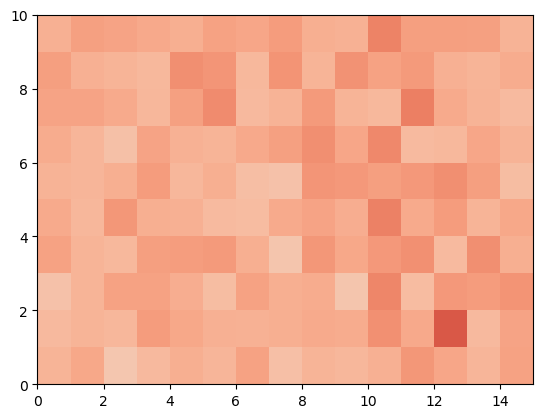

In [22]:
plt.pcolormesh(np.mean(pgw_data[:,:,:,0], axis=0)-np.mean(ctr_data[:,:,:,0], axis=0), vmin=-2.5,vmax=2.5, cmap='coolwarm')
plt.show()

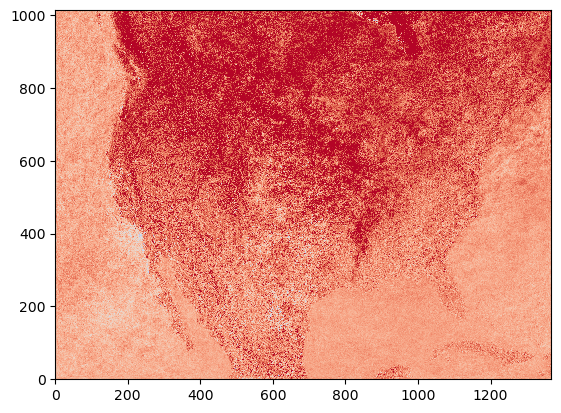

In [23]:
plt.pcolormesh(np.mean(ymax_pgw[:,:,:,1], axis=0) - np.mean(ymax_ctr[:,:,:,1], axis=0), vmin=-2.5,vmax=2.5, cmap='coolwarm')
plt.show()

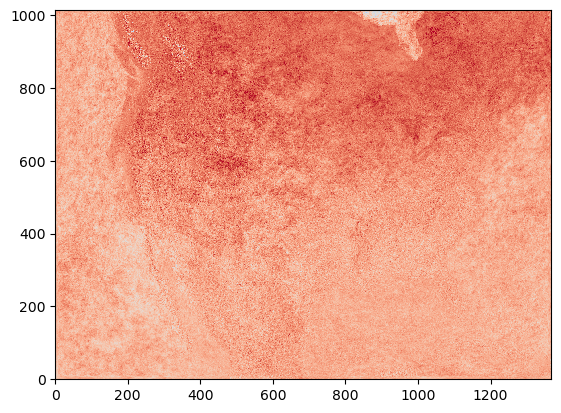

In [24]:
va = 0
plt.pcolormesh(np.mean(ymax_pgw[:,:,:,va], axis=0) - np.mean(ymax_ctr[:,:,:,va], axis=0), vmin=-2.5,vmax=2.5, cmap='coolwarm')
plt.show()

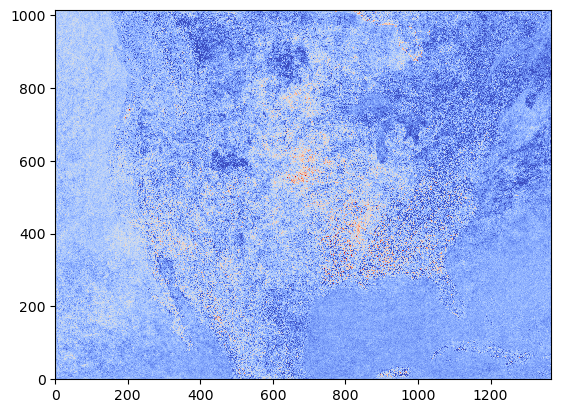

In [25]:
# variables = ['GWBT','T2','Q2','PSFC','U10','V10','LWDNB','SWDNB','LWUPB','SWUPB']
va = variables.index('Q2')
plt.pcolormesh((np.mean(ymax_pgw[:,:,:,va], axis=0) - np.mean(ymax_ctr[:,:,:,va], axis=0))*1000, vmin=-2.5,vmax=2.5, cmap='coolwarm_r')
plt.show()

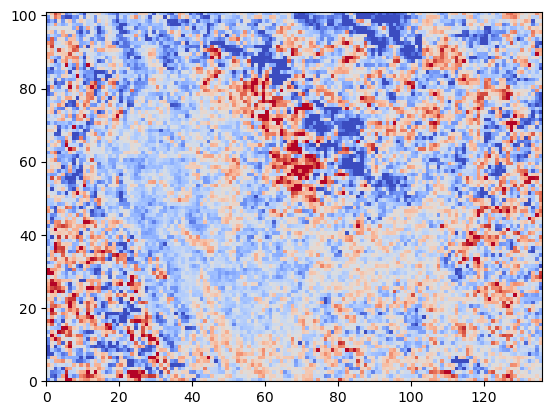

In [26]:
# variables = ['GWBT','T2','Q2','PSFC','U10','V10','LWDNB','SWDNB','LWUPB','SWUPB']
va = variables.index('SWDNB')
gc=10
data_pgw = np.mean(ymax_pgw[:,:,:,va], axis=0)
data_ctr = np.mean(ymax_ctr[:,:,:,va], axis=0)

def coarsen(data,
            factor):
    data = np.reshape(data[:int(int(data.shape[0]/factor)*factor),
                           :int(int(data.shape[1]/factor)*factor)], 
                             (int(data.shape[0]/factor),
                             factor,
                             int(data.shape[1]/factor),
                             factor))
    return np.mean(data, axis = (1,3))

plt.pcolormesh(coarsen(data_pgw, gc) - coarsen(data_ctr, gc), vmin=-25,vmax=25, cmap='coolwarm')
plt.show()

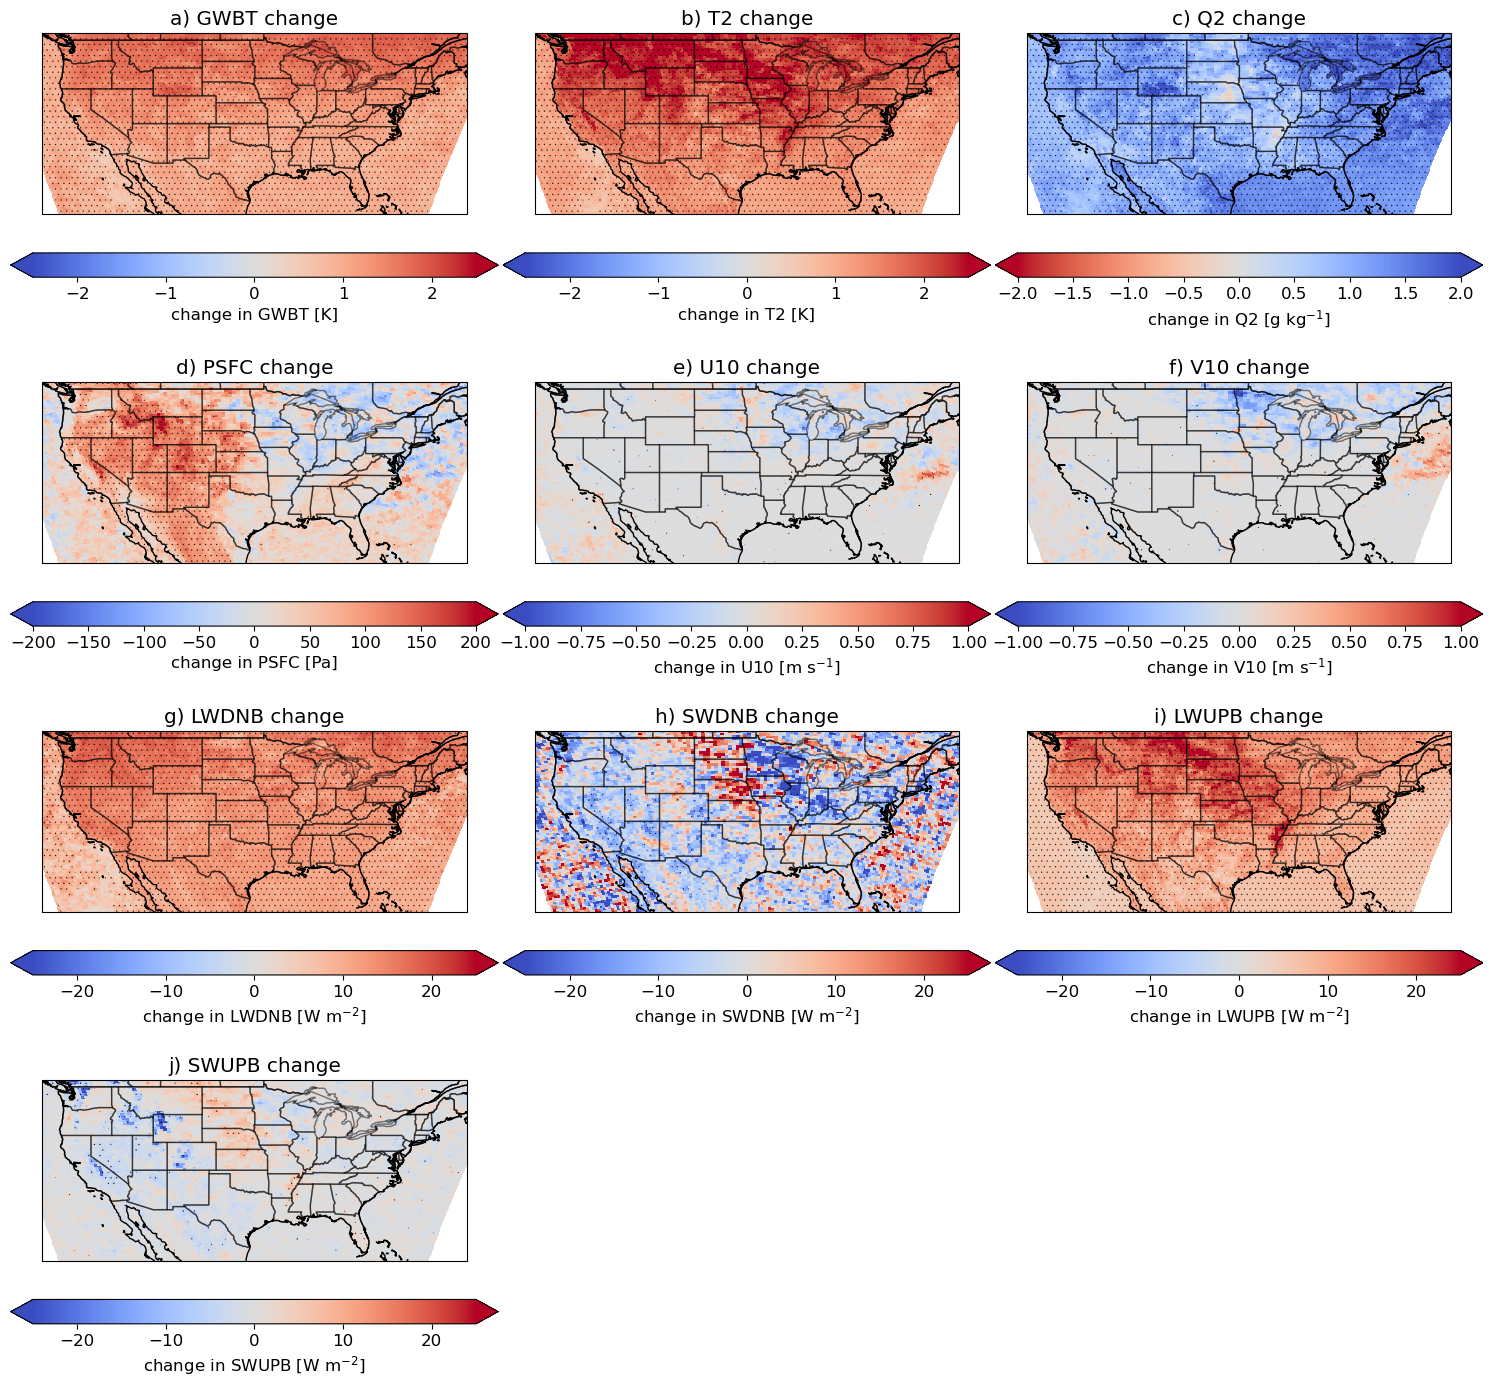

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
mpl.rcParams['hatch.linewidth'] = 0.1  # previous pdf hatch linewidth

gc=10
def coarsen(data,
            factor):
    data = np.reshape(data[:int(int(data.shape[0]/factor)*factor),
                           :int(int(data.shape[1]/factor)*factor)], 
                             (int(data.shape[0]/factor),
                             factor,
                             int(data.shape[1]/factor),
                             factor))
    return np.mean(data, axis = (1,3))

def coarsen3d(data,
            factor):
    data = np.reshape(data[:,:int(int(data.shape[1]/factor)*factor),
                             :int(int(data.shape[2]/factor)*factor)], 
                             (data.shape[0],
                              int(data.shape[1]/factor),
                             factor,
                             int(data.shape[2]/factor),
                             factor))
    return np.mean(data, axis = (2,4))

fig = plt.figure(figsize=(16, 15))
plt.rcParams.update({"font.size": 12})
gs1 = gridspec.GridSpec(4, 3)
gs1.update(left=0.04, right=0.96, bottom=0.08, top=0.95, wspace=0.01, hspace=0.35)
from string import ascii_lowercase
rgsLableABC = list(ascii_lowercase)

XX = [0,1,2,0,1,2,0,1,2,0]
YY = [0,0,0,1,1,1,2,2,2,3]

# ['GWBT', 'T2', 'Q2', 'PSFC', 'U10', 'V10', 'LWDNB', 'SWDNB', 'LWUPB', 'SWUPB']
unit = ['K','K','g kg$^{-1}$','Pa','m s$^{-1}$','m s$^{-1}$','W m$^{-2}$','W m$^{-2}$','W m$^{-2}$','W m$^{-2}$']
var_ranges = [2.5,2.5, 2,200,1,1,25,25,25,25]
for va in range(len(variables)):
    data_pgw = np.mean(ymax_pgw[:,:,:,va], axis=0)
    data_ctr = np.mean(ymax_ctr[:,:,:,va], axis=0)

    sig = scipy.stats.mannwhitneyu(coarsen3d(ymax_pgw[:,:,:,va], gc), 
                             coarsen3d(ymax_ctr[:,:,:,va], gc), axis = 0)

    if variables[va] == 'Q2':
        data_pgw = data_pgw*1000
        data_ctr = data_ctr*1000
        cmap = 'coolwarm_r'
    else:
        cmap = 'coolwarm'
    
    ax = plt.subplot(gs1[YY[va], XX[va]], projection=ccrs.PlateCarree())
    
    # plt.pcolormesh(rgrLon_c, rgrLat_c, hail_freq,
    #               cmap=hail_prob_cmap, norm=norm, transform=ccrs.PlateCarree())
    plt.pcolormesh(coarsen(lon_conus, gc), coarsen(lat_conus, gc),
                   coarsen(data_pgw, gc) - coarsen(data_ctr, gc), 
                   vmin=-var_ranges[va],vmax=var_ranges[va], cmap=cmap,
                   transform=ccrs.PlateCarree())
    
    # Add coastlines and borders
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=0.5)
    # Add US states
    ax.add_feature(cfeature.STATES, linestyle='-', edgecolor='black', alpha=0.5)
    
    # Set extent to North America
    ax.set_extent([-127, -66, 24, 50], crs=ccrs.PlateCarree())
    
    # # Add gridlines
    # gl = ax.gridlines(draw_labels=True)
    # gl.bottom_labels=False
    # gl.right_labels=False
    
    # Title
    plt.title(rgsLableABC[va] +') '+ variables[va]+' change')

    # Add a colorbar
    plt.colorbar(label='change in '+variables[va] + ' [' + unit[va] + ']', 
                 orientation='horizontal', extend = 'both')

    # add significance layer
    ax.contourf(
        coarsen(lon_conus, gc), coarsen(lat_conus, gc), 
        sig.pvalue < 0.05,
        transform=ccrs.PlateCarree(),
        colors='none',
        levels=[.5,1.5],
        hatches=['...',''],
    )
    
    # plt.contourf(coarsen(lon_conus, gc), coarsen(lat_conus, gc),
    #              sig.pvalue, levels=[0.05,1], hatches=["", "."], alpha=0,
    #              transform=ccrs.PlateCarree())


    
plt.show()

# fig.savefig(sSaveDataDir+'Map-hail-frequency_'+var_string_+'_'+str(ii).zfill(2)+'.pdf', bbox_inches='tight') #, dpi=700)

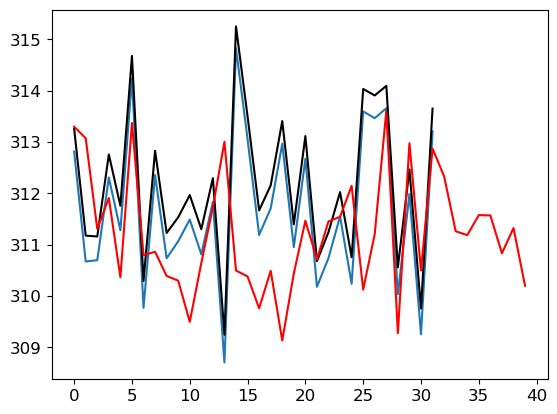

In [58]:
ce = 0

plt.plot(change_sensitivities[:,0,ce,0])
plt.plot(pgw_original_data[:,0,ce], c='k')
plt.plot(ctr_original_data[:,0,ce], c='r')
plt.show()

### Plot change attribution

In [59]:
change_var_categories = ['T2','Q2','PSFC','UV10', 'LW', 'SW']
change_cat_colors = ['#e31a1c','#1f78b4','#969696','#33a02c','#a6cee3','#fb9a99']

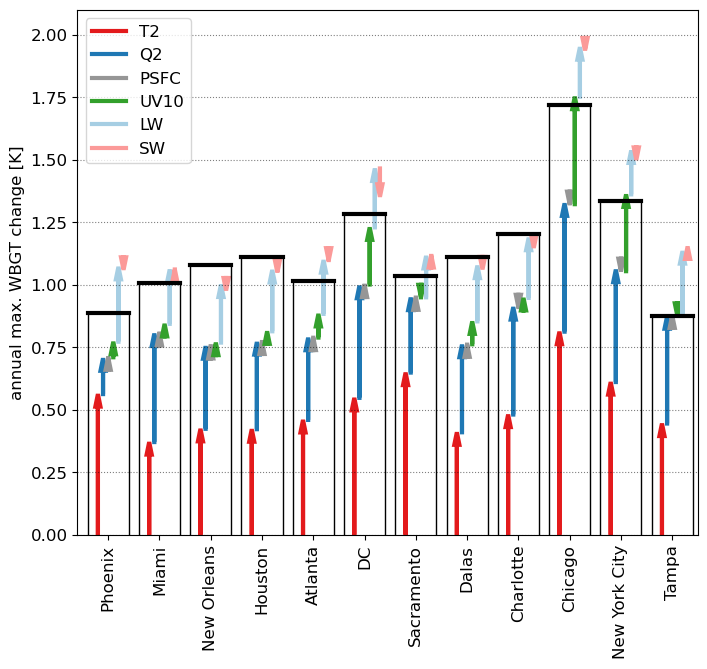

In [60]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({'font.size': 12})


fig = plt.figure(figsize=(15,15))
# Histogram plots
gs1 = gridspec.GridSpec(2,2) #rgiSize[2])
gs1.update(left=0.06, right=0.97,
           bottom=0.13, top=0.97,
           wspace=0.20, hspace=0.40)

for cy in range(len(cities)):
    ax = plt.subplot(gs1[0,0])
    
    mean_change = np.nanmedian(pgw_original_data[:,cy,:]) - np.nanmedian(ctr_original_data[:,cy,:])
    # ax.bar('$\Delta$GWBT$_{max}$',mean_change, align='center', color='k', width=0.1)
    
    plt.plot([0.1+cy,0.1+cy],[0,mean_change], c='k', lw=1)
    plt.plot([0.9+cy,0.9+cy],[0,mean_change], c='k', lw=1)
    plt.plot([0.1+cy,0.9+cy],[mean_change,mean_change], c='k', lw=3)
    
    # Add the components from different variables
    orig_change = np.nanmedian(pgw_original_data[:,cy,:]) - np.nanmedian(ctr_original_data[:,cy,:])
    mean_change_vars = (np.nanmedian(change_sensitivities[:,cy,:,:], axis=(0,1)) - np.nanmedian(ctr_original_data[:,cy,:]))
    change_deltas = orig_change - (np.nanmedian(change_sensitivities[:,cy,:,:], axis=(0,1)) - np.nanmedian(ctr_original_data[:,cy,:]))
    
    for va in range(change_sensitivities.shape[3]):
        if va == 0:
            start = 0
        else:
            start = np.sum(change_deltas[:va])
        plt.arrow(0.3+0.1*va + cy, start, 0, np.sum(change_deltas[:va+1])-start, length_includes_head=True,
                  head_width=0.1, head_length=0.05,
                  color=change_cat_colors[va],
                  lw=3)
    
    plt.xlim(-0.1, len(cities))
    plt.ylim(0, 2.1)

for va in range(change_sensitivities.shape[3]):
    plt.plot([],[], label = change_var_categories[va], lw = 3, color = change_cat_colors[va])
plt.legend()

ax.set_xticks(np.array(range(len(cities)))+0.5)
ax.set_xticklabels(cities, rotation=90)

plt.grid(which='major', color='k', linestyle=':', axis='y', alpha = 0.5)
plt.grid(which='minor', color='k', linestyle=':', axis='y', alpha = 0.5)

plt.ylabel('annual max. WBGT change [K]')

plt.show()

In [ ]:
cy=0
np.nanmean(pgw_original_data[:,cy,:]) - np.nanmean(ctr_original_data[:,cy,:])

In [ ]:
np.nanmean(pgw_original_data[:,0,:]) - np.mean(ctr_original_data[:,0,:])

In [ ]:
ctr_original_data[:,0,:]

In [ ]:
change_sensitivities.shape

In [ ]:
change_sensitivities.shape

In [ ]:
ctr_original_data.shape

In [ ]:
stop()

In [ ]:
ctr_data_sel

In [ ]:
ctr_data_sel.shape

In [ ]:
va = 0
cy = 0
ce = 4

plt.plot(change_sensitivities[:,cy,ce,va])
plt.plot(pgw_original_data[:,cy,ce], c='k')

In [ ]:
plt.plot(pgw_original_data[:,cy,:], c='k')

In [ ]:
wbgt_test

In [ ]:
pgw_data[yy,0]

In [ ]:
pgw_data[yy,:]

In [ ]:
np.array(huss[:1,500:501,600:601]),
                np.array(tas[:1,500:501,600:601]),
                np.array(ps[:1,500:501,600:601]),
                np.array(uas[:1,500:501,600:601]),
                np.array(vas[:1,500:501,600:601]),
                np.array(rlds[:1,500:501,600:601]),
                np.array(rsds[:1,500:501,600:601]),
                np.array(rlus[:1,500:501,600:601]),
                np.array(rsus[:1,500:501,600:601]),

In [ ]:
ctr_data.shape

In [ ]:
va=4
plt.plot(years_ctr,ctr_data[:,va])
plt.plot(years_pgw+42, pgw_data[:,va])
plt.plot(years_pgw+42, pgw_data_noTchange[:,va], c='k')

In [ ]:
wbgt_test

In [ ]:
import numpy as np
import statsmodels.api as sm

yy = np.nanmean(ymax_ctr[:,city_loc[cy][1][0]:city_loc[cy][1][1], \
                 city_loc[cy][0][0]:city_loc[cy][0][1],0][:,city_gc], axis=1)

xx = np.nanmean(ymax_ctr[:,city_loc[cy][1][0]:city_loc[cy][1][1], \
                 city_loc[cy][0][0]:city_loc[cy][0][1],1:][:,city_gc], axis=1).T

# # center y values to reduce high cond. no.
# xx = xx - np.average(xx, axis=1)[:, None]

def reg_m(y, x):
    x = x[::-1]
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

In [ ]:
print(reg_m(yy, xx).summary())

In [ ]:
plt.scatter(xx[1,:], yy)


In [ ]:
xx.shape